In [ ]:
!pip install pykan

In [ ]:
!pip show pykan

Name: pykan
Version: 0.2.8
Summary: Kolmogorov Arnold Networks
Home-page: 
Author: Ziming Liu
Author-email: zmliu@mit.edu
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: 
Required-by: 


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from kan import KAN
import uuid

# Установка сида для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

# Проверка доступности CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Генерация данных
def true_function(x):
    if isinstance(x, (np.ndarray, list)):
        x = np.asarray(x)
        result = np.zeros_like(x)
        mask_neg = x < 0
        mask_pos = x >= 0

        # Обработка x < 0
        result[mask_neg] = x[mask_neg]**2 * np.sin(5 * x[mask_neg])

        # Обработка x >= 0
        result[mask_pos] = 1 / (1 + np.exp(-x[mask_pos])) + 0.2 * np.sign(x[mask_pos])

        return result
    else:
        # Скалярный случай
        if x < 0:
            return x**2 * np.sin(5 * x)
        else:
            return 1 / (1 + np.exp(-x)) + 0.2 * np.sign(x)

x_train_kan = np.linspace(-2, 2, 200).reshape(-1, 1)
y_train_kan = true_function(x_train_kan)
x_test_kan = np.linspace(-2, 2, 100).reshape(-1, 1)
y_test_kan = true_function(x_test_kan)

x_train_mlp = np.linspace(-2, 2, 2000).reshape(-1, 1)
y_train_mlp = true_function(x_train_mlp)
x_test_mlp = np.linspace(-2, 2, 200).reshape(-1, 1)
y_test_mlp = true_function(x_test_mlp)

In [ ]:
# Перенос тензоров на устройство
x_train_tensor_kan = torch.tensor(x_train_kan, dtype=torch.float32).to(device)
y_train_tensor_kan = torch.tensor(y_train_kan, dtype=torch.float32).to(device)
x_test_tensor_kan = torch.tensor(x_test_kan, dtype=torch.float32).to(device)
y_test_tensor_kan = torch.tensor(y_test_kan, dtype=torch.float32).to(device)

x_train_tensor_mlp = torch.tensor(x_train_mlp, dtype=torch.float32).to(device)
y_train_tensor_mlp = torch.tensor(y_train_mlp, dtype=torch.float32).to(device)
x_test_tensor_mlp = torch.tensor(x_test_mlp, dtype=torch.float32).to(device)
y_test_tensor_mlp = torch.tensor(y_test_mlp, dtype=torch.float32).to(device)

In [ ]:
# Определение MLP архитектур
class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.layers.append(nn.ReLU())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
# Функция обучения MLP с сохранением истории ошибок
def train_mlp(model, x, y, epochs=1000, lr=0.01):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    loss_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
    return model, loss_history

In [ ]:
# Создание трех MLP с разными гиперпараметрами
mlp_configs = [
    {"layers": [1, 10, 10, 1], "epochs": 100, "lr": 0.01, "name": "MLP Simple"},
    {"layers": [1, 50, 50, 1], "epochs": 200, "lr": 0.005, "name": "MLP Medium"},
    {"layers": [1, 100, 100, 100, 1], "epochs": 300, "lr": 0.001, "name": "MLP Deep"},
]

mlp_models = []
mlp_predictions = []
mlp_mse = []
mlp_loss_histories = []

for config in mlp_configs:
    mlp_model = MLP(config["layers"])
    mlp_model, loss_history = train_mlp(mlp_model, x_train_tensor_mlp, y_train_tensor_mlp, config["epochs"], config["lr"])
    mlp_models.append(mlp_model)
    mlp_loss_histories.append(loss_history)
    with torch.no_grad():
        y_pred = mlp_model(x_test_tensor_mlp).cpu().numpy()  # Перенос на CPU для numpy
        mlp_predictions.append(y_pred)
        mse = np.mean((y_pred - y_test_mlp)**2)
        mlp_mse.append(mse)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.02e-02 | test_loss: 3.69e-02 | reg: 6.21e+00 | : 100%|█| 200/200 [01:30<00:00,  2.21


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.18e-02 | test_loss: 4.03e-02 | reg: 1.45e+01 | : 100%|█| 200/200 [01:11<00:00,  2.78


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.43e-02 | test_loss: 2.88e-02 | reg: 1.11e+01 | : 100%|█| 200/200 [01:05<00:00,  3.07


saving model version 0.1


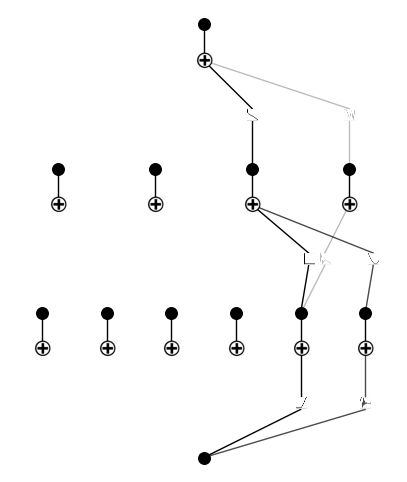

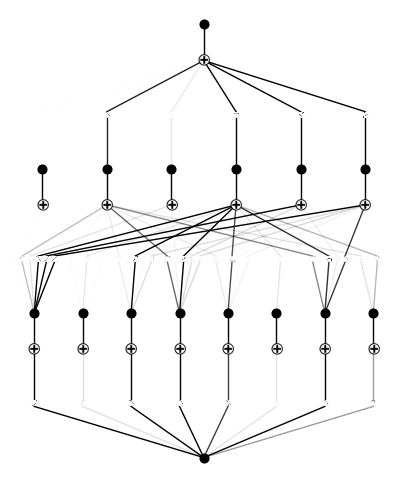

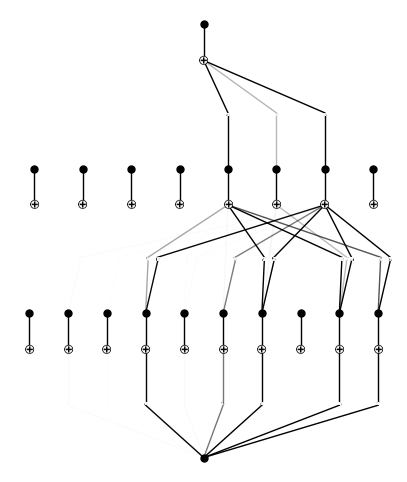

In [ ]:
# Создание и обучение KAN моделей
kan_configs = [
    {
        "width": [1, 6, 4, 1],
        "grid": 16,               
        "k": 4,                  
        "lamb": 0.1,              
        "name": "KAN simple"
    },
    {
        "width": [1, 8, 6, 1],
        "grid": 16,               
        "k": 4,                   
        "lamb": 0.1,              
        "name": "KAN medium"
    },
    {
        "width": [1, 10, 8, 1], 
        "grid": 16,             
        "k": 4,                   
        "lamb": 0.1,              
        "name": "KAN deep"
    }
]
kan_models = []
kan_predictions = []
kan_mse = []
kan_loss_histories = []

for config in kan_configs:
    kan_model = KAN(width=config["width"], grid=config["grid"], k=config["k"], device=device)
    dataset = {
        "train_input": x_train_tensor_kan,
        "train_label": y_train_tensor_kan,
        "test_input": x_test_tensor_kan,
        "test_label": y_test_tensor_kan
    }
    results = kan_model.fit(dataset, opt="LBFGS", steps=200, lamb=0.01)
    kan_model(dataset['train_input']);
    kan_model.plot(beta=100)
    kan_models.append(kan_model)
    y_pred = kan_model(x_test_tensor_kan).detach().cpu().numpy()  # Перенос на CPU для numpy
    kan_predictions.append(y_pred)
    mse = np.mean((y_pred - y_test_kan)**2)
    kan_mse.append(mse)
    # Сохранение истории лоссов (train_loss из результатов fit)
    kan_loss_histories.append(results['train_loss'])


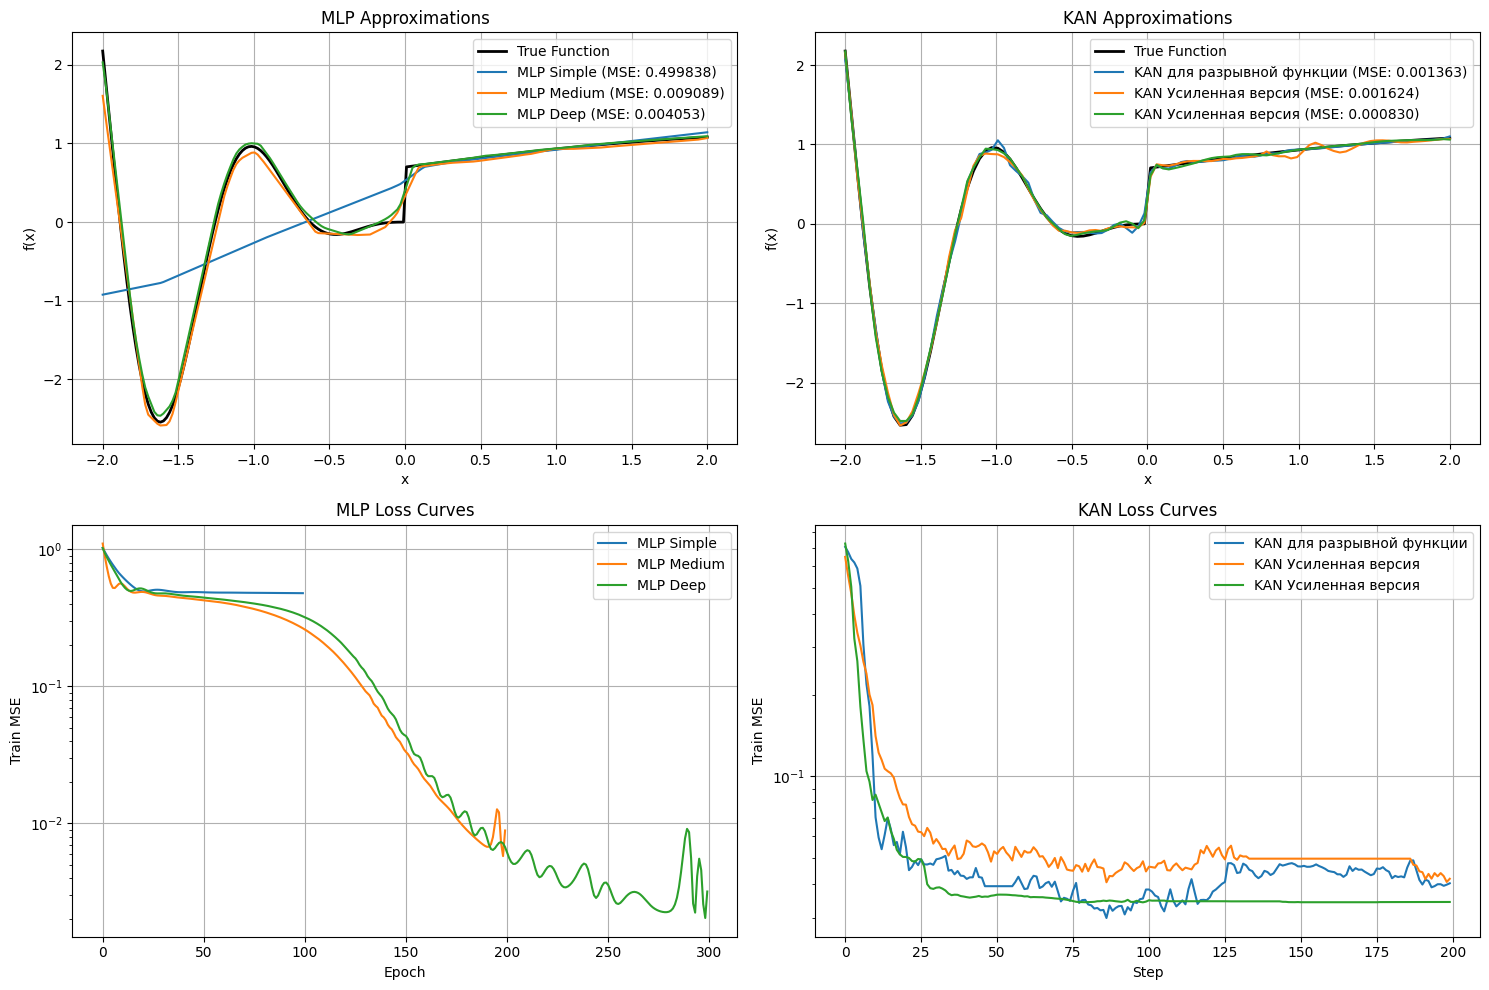

In [ ]:
# Визуализация аппроксимаций
plt.figure(figsize=(15, 10))

# График для MLP
plt.subplot(2, 2, 1)
plt.plot(x_test_mlp, y_test_mlp, label="True Function", color="black", linewidth=2)
for i, pred in enumerate(mlp_predictions):
    plt.plot(x_test_mlp, pred, label=f"{mlp_configs[i]['name']} (MSE: {mlp_mse[i]:.6f})")
plt.title("MLP Approximations")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)

# График для KAN
plt.subplot(2, 2, 2)
plt.plot(x_test_kan, y_test_kan, label="True Function", color="black", linewidth=2)
for i, pred in enumerate(kan_predictions):
    plt.plot(x_test_kan, pred, label=f"{kan_configs[i]['name']} (MSE: {kan_mse[i]:.6f})")
plt.title("KAN Approximations")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)

# Визуализация изменения ошибок для MLP
plt.subplot(2, 2, 3)
for i, loss_history in enumerate(mlp_loss_histories):
    plt.plot(range(len(loss_history)), loss_history, label=mlp_configs[i]['name'])
plt.title("MLP Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Train MSE")
plt.legend()
plt.grid(True)
plt.yscale("log")  # Логарифмическая шкала для лучшей видимости

# Визуализация изменения ошибок для KAN
plt.subplot(2, 2, 4)
for i, loss_history in enumerate(kan_loss_histories):
    plt.plot(range(len(loss_history)), loss_history, label=kan_configs[i]['name'])
plt.title("KAN Loss Curves")
plt.xlabel("Step")
plt.ylabel("Train MSE")
plt.legend()
plt.grid(True)
plt.yscale("log")  # Логарифмическая шкала для лучшей видимости

plt.tight_layout()
plt.savefig("mlp_kan_comparison.png")

In [ ]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    kan_model.fix_symbolic(0,0,0,'sin');
    kan_model.fix_symbolic(0,1,0,'x^2');
    kan_model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs', 'cos']
    kan_model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.004717708565294743, c=1
fixing (0,0,1) with x, r2=0.0014562958385795355, c=1
fixing (0,0,2) with x, r2=0.0035035579930990934, c=1
fixing (0,0,3) with x, r2=0.4075911045074463, c=1
fixing (0,0,4) with x, r2=0.09810756891965866, c=1
fixing (0,0,5) with x, r2=0.5436499714851379, c=1
fixing (0,0,6) with x, r2=0.9084974527359009, c=1
fixing (0,0,7) with x, r2=0.05266128107905388, c=1
fixing (0,0,8) with x, r2=0.8485934734344482, c=1
fixing (0,0,9) with x, r2=0.45701393485069275, c=1
fixing (1,0,0) with x, r2=1.2225151557743175e-08, c=1
fixing (1,0,1) with x, r2=2.917546759739764e-10, c=1
fixing (1,0,2) with x, r2=4.770653845298511e-07, c=1
fixing (1,0,3) with x, r2=3.688640504151408e-08, c=1
fixing (1,0,4) with x, r2=8.570522763706734e-11, c=1
fixing (1,0,5) with x, r2=1.2480165789696684e-09, c=1
fixing (1,0,6) with x, r2=7.392934056821635e-14, c=1
fixing (1,0,7) with x, r2=3.387577163227462e-10, c=1
fixing (1,1,0) with x, r2=9.352526717520959e-07, c=1
fixing (1,

In [ ]:
kan_model.symbolic_formula()[0][0]

0.497572599278051*x_1 - 6.29323581638002e-7*exp(0.00566371622552572*x_1) + 2.5603103869064e-8*exp(0.0901904541835655*x_1) + 1.65771535408144e-6*exp(0.0960341649482624*x_1) + 0.340023015054372 - 7.95381174522585e-9*exp(-0.00177299441776278*x_1) + 7.36320882759638e-5*exp(-0.00177297311293636*x_1) - 0.0017376711390952*exp(-0.00177104401163018*x_1) + 6.88879436466236e-5*exp(-0.000384793827729152*x_1)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"KAN params: {count_parameters(kan_model)}")
print(f"MLP params: {count_parameters(mlp_model)}")

KAN params: 2548
MLP params: 20501


In [ ]:
def plot_kan_curvature(model):
    for i, module in enumerate(model.modules()):
        if hasattr(module, 'splines'):  # ищем KAN-специфичный слой
            plt.figure(figsize=(6, 3))
            for j, spline in enumerate(module.splines):
                x = np.linspace(spline.xmin, spline.xmax, 200)
                y = spline(x)
                dy = spline.derivative(1)(x)
                ddy = spline.derivative(2)(x)
                plt.plot(x, ddy, label=f"Spline {j}")
            plt.title(f"Curvature in Layer {i}")
            plt.xlabel("x")
            plt.ylabel("Curvature")
            plt.legend()
            plt.tight_layout()
            plt.show()

In [ ]:
plot_kan_curvature(kan_model)